## Problem Statement

Given the data set, predict the expenses and income of the given sample of 10k Users.

## Approach

1. Do a quick exploratory analysis to understand feature distribution and data in general. 
2. Fix issues discovered in exploratory data analysis such as outliers, missing values etc.
3. Create a baseline model with existing features, if features are not available, create new features using feature engineering.
4. Model Training
5. Evaluate the model using an appropriate error metric.

In [44]:
import pandas as pd
from pandas import np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from pandas import np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve

In [2]:
train = pd.read_csv('Data Science Task/2016-09-19_79351_training.csv', parse_dates=['transaction_date'])
card_group = pd.read_csv('Data Science Task/mcc_group_definition.csv')
transaction = pd.read_csv('Data Science Task/transaction_types.csv')

# uncomment lines below to run predictions for aug data
# PATH_TO_AUG_DATA = ?
# aug_data = pd.read_csv(PATH_TO_AUG_DATA)

In [3]:
train.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training


In [4]:
train.isna().sum(axis=0)

user_id                     0
transaction_date            0
transaction_type            0
mcc_group              150222
amount_n26_currency         0
dataset_transaction         0
dataset_user                0
dtype: int64

In [5]:
for col in train.columns:
    display(train[col].describe(include='all'))

count                               408546
unique                               10000
top       d4ba03459f726f32bf24fe3801c24958
freq                                   483
Name: user_id, dtype: object

count                  408546
unique                    182
top       2016-07-06 00:00:00
freq                     5393
first     2016-02-01 00:00:00
last      2016-07-31 00:00:00
Name: transaction_date, dtype: object

count     408546
unique         9
top           PT
freq      258324
Name: transaction_type, dtype: object

count    258324.000000
mean          4.840166
std           4.574400
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max          17.000000
Name: mcc_group, dtype: float64

count    408546.000000
mean         52.764164
std         111.870681
min           3.000000
25%           7.000000
50%          17.000000
75%          38.000000
max        1166.000000
Name: amount_n26_currency, dtype: float64

count       408546
unique           1
top       training
freq        408546
Name: dataset_transaction, dtype: object

count       408546
unique           1
top       training
freq        408546
Name: dataset_user, dtype: object

In [6]:
for col in transaction.columns:
    display(transaction[col].describe(include='all'))

count      23
unique     23
top       BUS
freq        1
Name: type, dtype: object

count                    23
unique                   23
top       Authorized Action
freq                      1
Name: explanation, dtype: object

count     23
unique     3
top       In
freq      11
Name: direction, dtype: object

count       23
unique       5
top       Card
freq         8
Name: agent, dtype: object

### Quick Insights

1. `train` contains transactional data for 10k users spread across seven months from Feb 2016 to Aug 2016.
2.  Except `mcc_group` feature in train data, no other feature contains missing values. It is only available for `transaction_type = Presentment`.
3. `amount_n26_currency` has a quite high standard deviation which mean the variable is skewed. We'll explore it better in visual data analysis below.
4. `train` contains two constant features `dataset_transaction` and `dataset_user`, we will drop them.
5. `card_group` contains explanation for each `mmc_group` in the train data. We'll join it with train. Also, `transcation` needs to be joined with `train`.

In [7]:
train = train.drop(['dataset_transaction','dataset_user'], axis=1)

In [8]:
# fix tags
card_group['explanation'] = card_group['explanation'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ', x).strip())
card_group['explanation'] = card_group['explanation'].apply(lambda x: re.sub(r'\s+', '_', x))

In [9]:
# merge data
train2 = train.merge(card_group, on='mcc_group', how='left').drop('mcc_group', axis=1)

train2 = (train2
          .merge(transaction, left_on='transaction_type', right_on='type', suffixes=('_card', '_transaction'))
          .drop(['type','transaction_type'], axis=1))

Now, we will explore the data using plots and try to discover some insights. Since the dataset is small, we'll visualise the trends on a weekly basis to better understand the user behaviour instead of montly basis. We'll start by writing some helper funcitons for plotting.

In [22]:
# helpers
def plot_bar(feature):
    g = sns.catplot(x=feature, 
                    data=train2,
                    order = train2[feature].value_counts().index,
                    kind='count', 
                    height=7, 
                    aspect = 3, 
                    palette="Paired", 
                    edgecolor=".6")
    g.set_xticklabels(rotation=90)

def weekly_popularity_trend(feature, **kwargs):
    """
    Feature popularity on weekly basis
    """
    f = train2.groupby([feature, pd.Grouper(key='transaction_date',freq='W')]).size().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [feature,'transaction_date','count']
    sns.catplot(x="transaction_date", 
            y = 'count',
            hue = feature, 
            data=f, 
            kind='point', 
            height=7, 
            aspect= 2,
            palette='Paired')
    _ = plt.xticks(rotation=90)

def weekly_currency_trend(**kwargs):
    """
    Mean transaction amount on a weekly basis for a given feature
    """
    feature = kwargs.get('feature', None)
    f = train2.groupby([*feature, pd.Grouper(key='transaction_date',freq='W')])['amount_n26_currency'].mean().reset_index()
    f['transaction_date'] = f['transaction_date'].dt.date
    f.columns = [*feature,'transaction_date','mean']
    hue = feature[0]
    val = None if len(feature) == 1 else feature[1] 
    aspect = 1 if val is not None else 2
    height = 10 if val is not None else 7
    g = sns.catplot(x="transaction_date", 
            y = 'mean',
            hue = hue,
            col = val,
            data=f, 
            kind='point', 
            height = height,
            aspect = aspect,
            palette=sns.color_palette("bright", 10)
            )
    g.set_xticklabels(rotation=90)

### Univariate

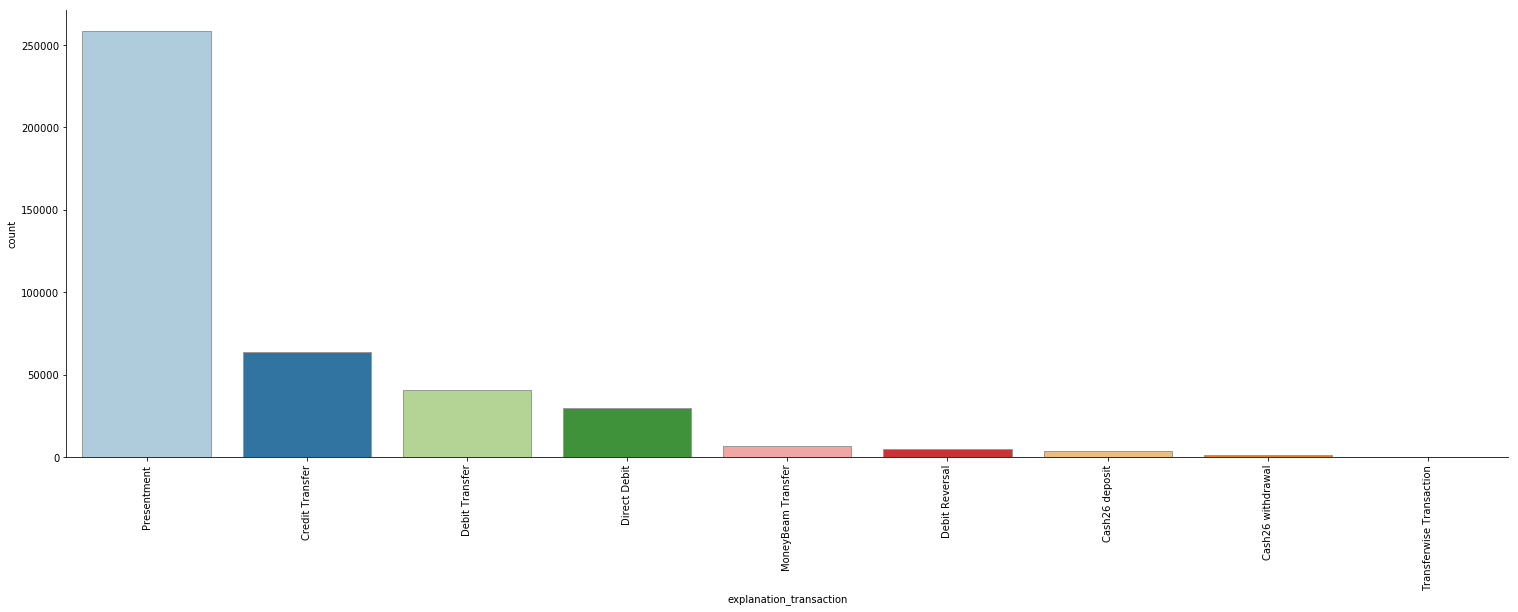

In [23]:
plot_bar('explanation_transaction')

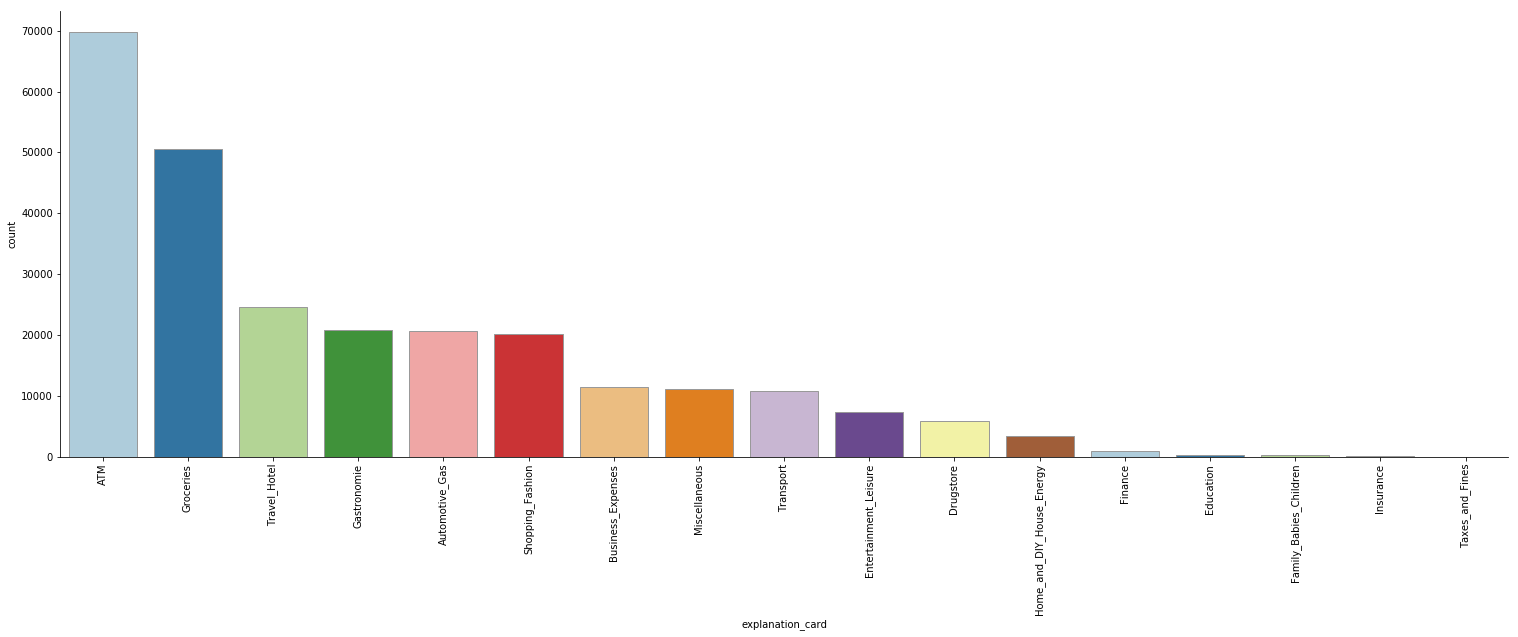

In [24]:
plot_bar('explanation_card')

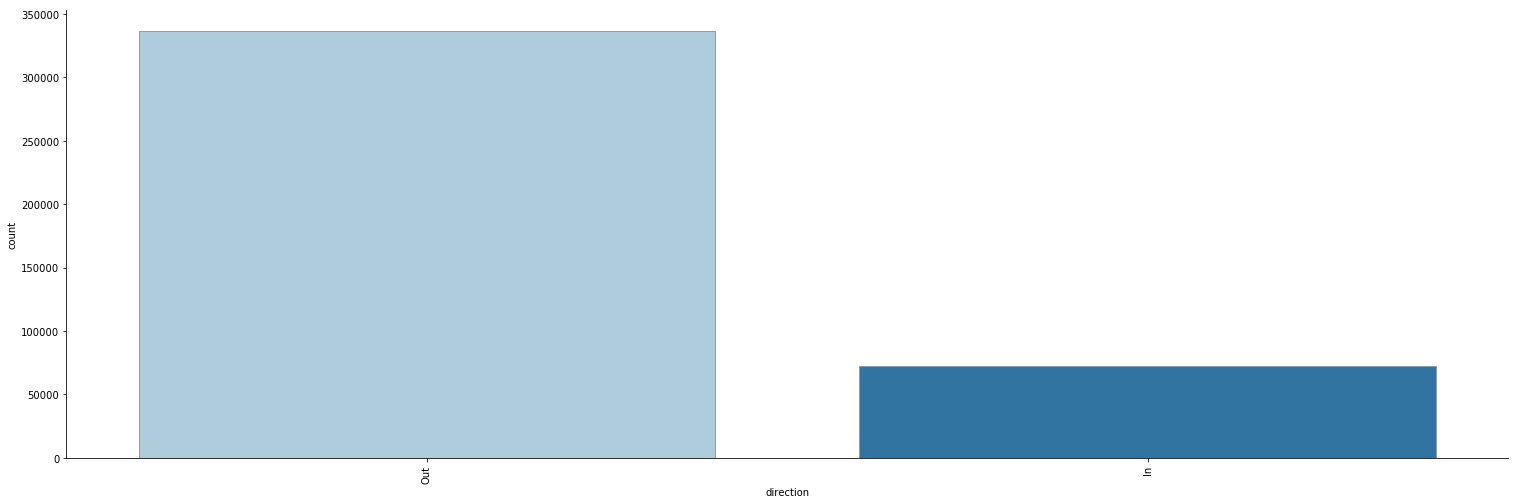

In [25]:
plot_bar('direction')

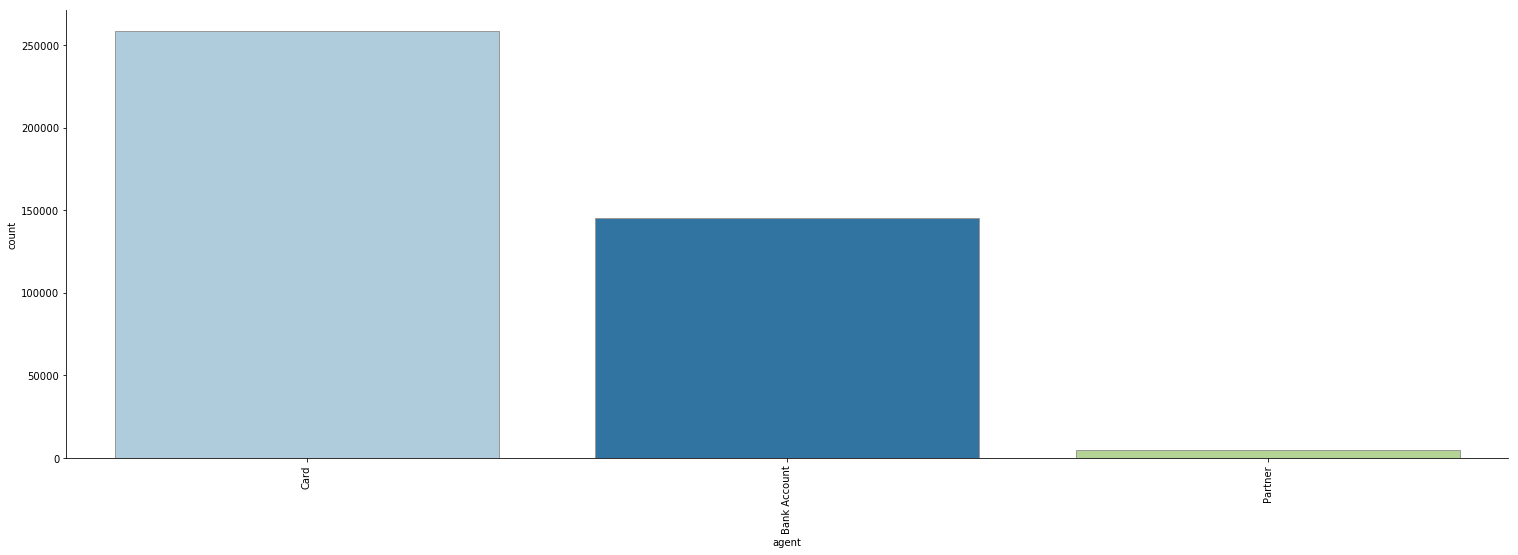

In [26]:
plot_bar('agent')

### Quick Insights

1. `Presentment` has highest number of transactions in the given data followed by credit transfer and debit transfer.
2. `ATM` is the most popular way people use to withdraw money, followed by using their money for groceries, travel_hotel, eating out etc.
3. Users make more debit transactions as compared to credit transactions, which is common to see.

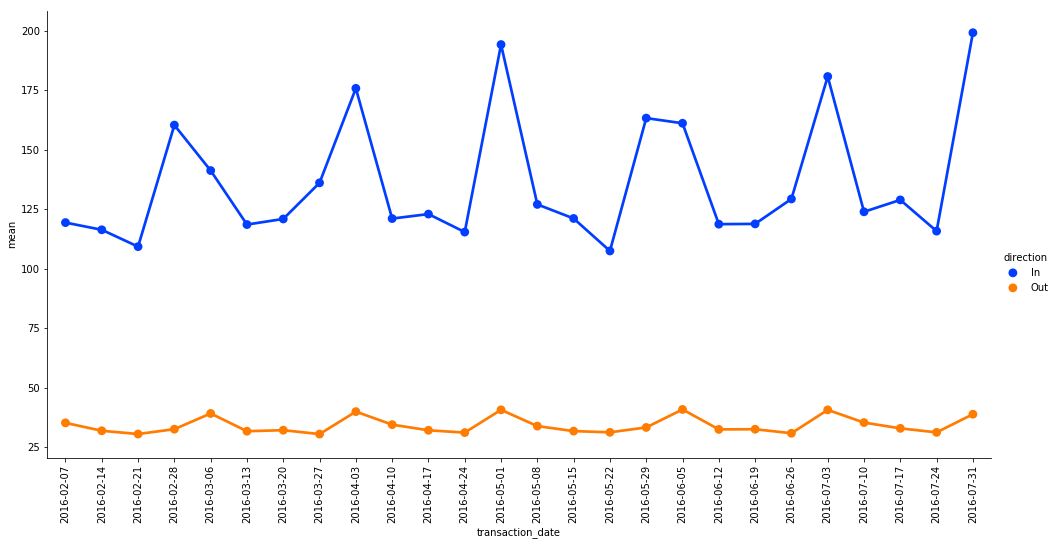

In [27]:
weekly_currency_trend(feature=['direction'])

**Observation**: We observe a peak in the last week of all months. Credit transfers tend to happen in the last week of the month. Looks, like a salary credit.

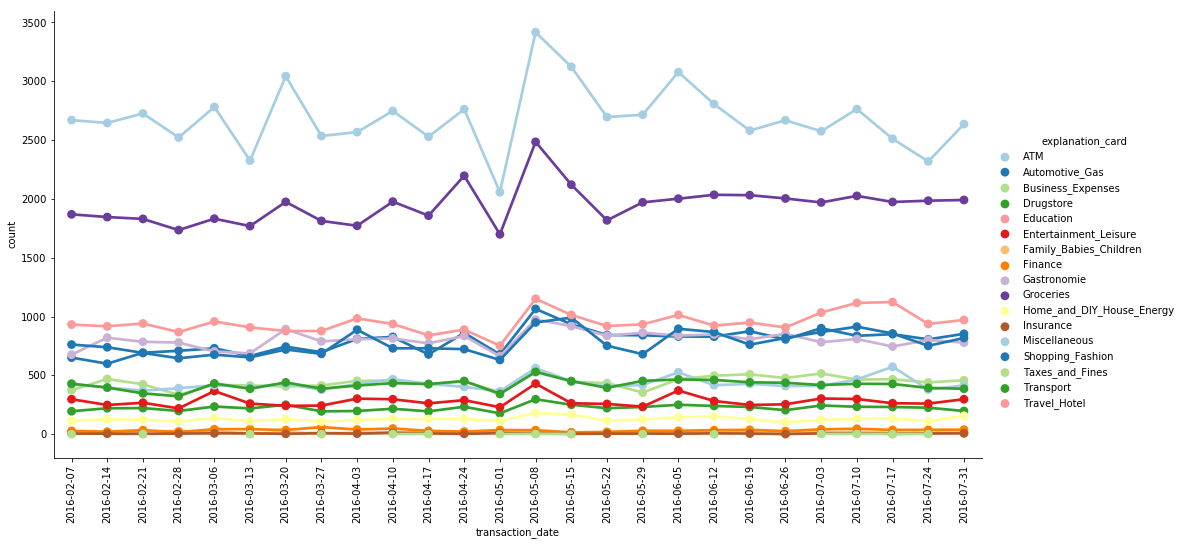

In [28]:
weekly_popularity_trend('explanation_card')

**Observation**: As seen above, `ATM` has the highest weekly usage. Also, we observe a peak in the last week of may. Good thing is, this peak is observed across all `explanation_card`. This means, during this week some activity / marketing campaign happened which impacted across most of the channels.

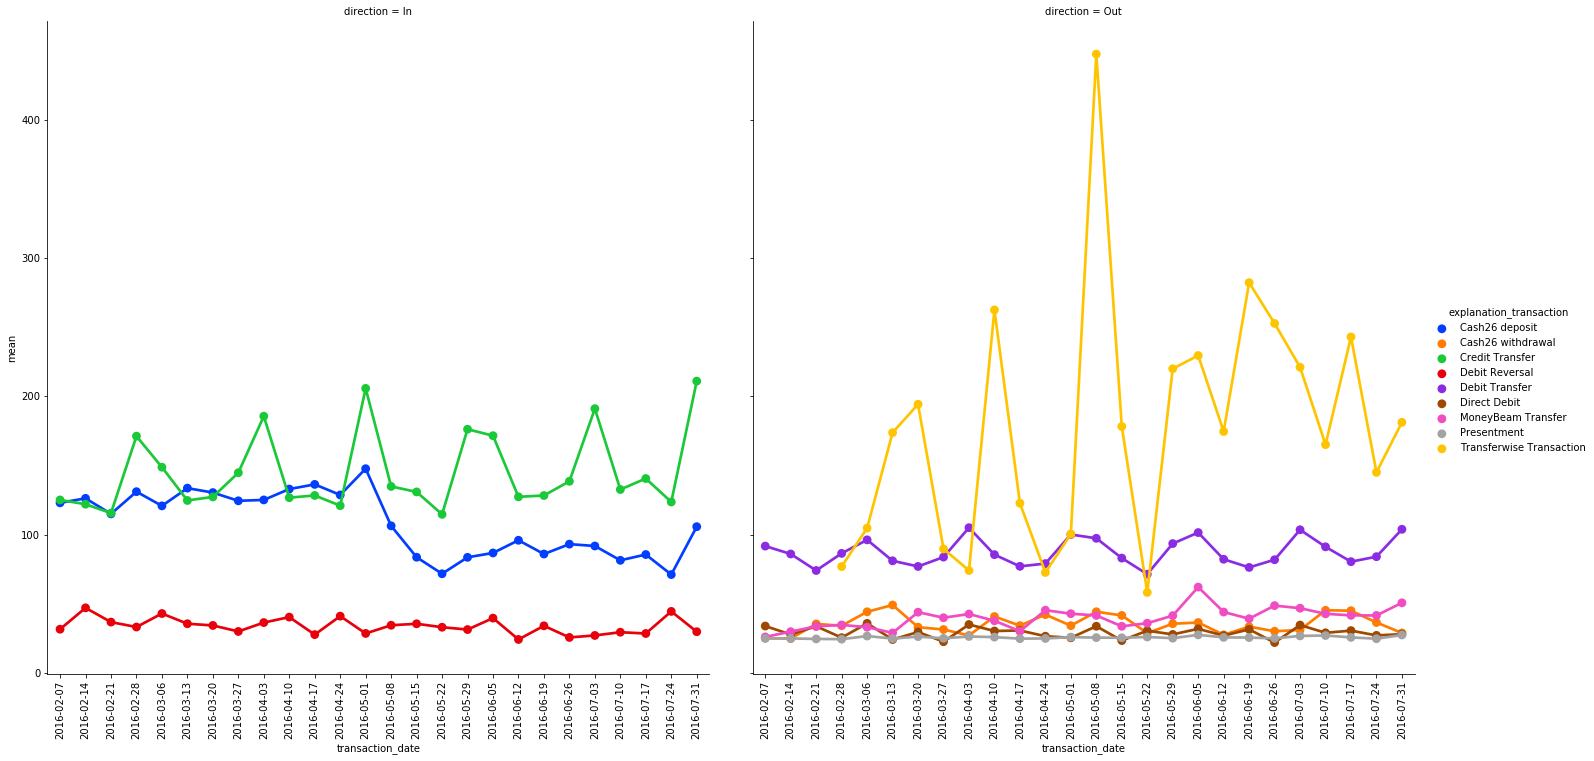

In [29]:
weekly_currency_trend(feature= ['explanation_transaction', 'direction'])

**Observation:** We see that the usage of transferwise is increasing over the weeks. Users are using transferwise more for making debit transactions, may be for doing international transfers.

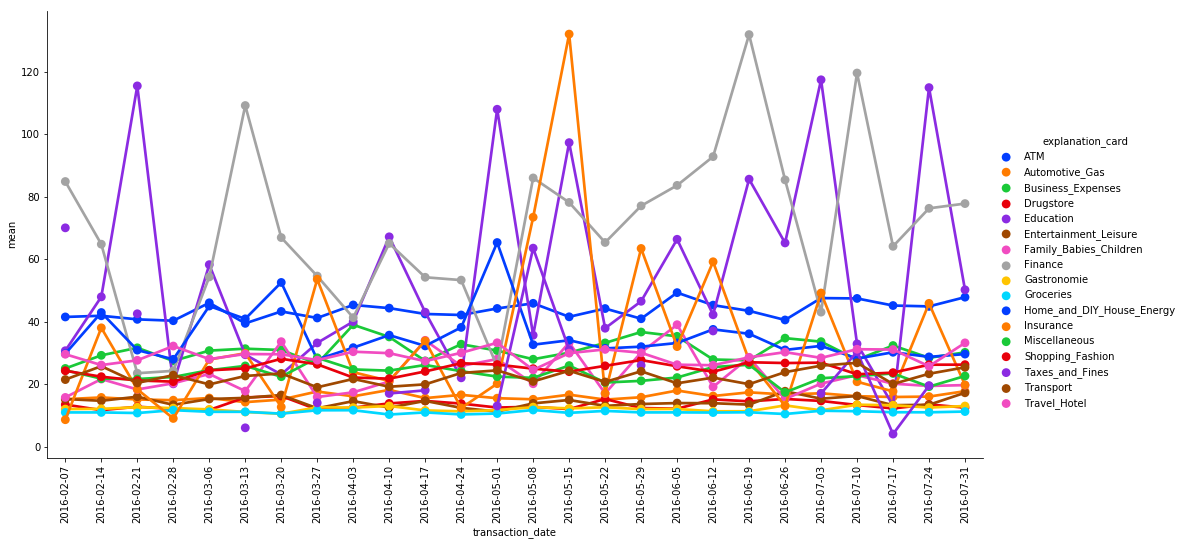

In [30]:
weekly_currency_trend(feature = ['explanation_card'])

**Observation:** We do not see a clear trend except different categories have peaks emerging in different months. Also, seems like, over tht time people are doing more financial activities, also the `Education` category is surfacing often. We observe some spikes in financial, education expenses over the weeks while the `ATM` mode follows a stable trend. 

We saw above the users do more debit transactions than credit transactions. We could say, that they make big credit transactions (like salary) and over the month use that money to make small (grocery, travel etc.) transactions to support their daily lives. Let's confirm this hypothesis now:

In [31]:
user_activity_price = (pd
                 .pivot_table(index='user_id', columns=['direction'], values='amount_n26_currency', aggfunc='mean', data=train2)
                 .rename_axis(None, axis=1)
                 .reset_index())

In [32]:
(user_activity_price['In'] > user_activity_price['Out']).value_counts(normalize=True)

True     0.7978
False    0.2022
dtype: float64

Indeed, we see that 80% of the users perform higher credit transction than their debit transction.

## Dataset Preparation

### Quick approach

1. We'll create two separate dataset for predicting `expenses/debit` and `income/credit` of the users.
2. We'll follow a time based local validation scheme where we'll consider data from Feb - June in training and make predictions on July data.
3. Also, we'll drop variables which get generated after transaction happens i.e. explanation_card, explanation_transaction. These are the variable that get generated after the transcation is done, hence we can't use them in training.
4. We will log transform the target variable `amount_n26_currency` since it is skewed. 
5. We'll use RMSLE (Root mean squared log error) to evaluate the model because:
  * Measuring errors on a logarithmic scale means that errors of the same relative size are treated the same. This way a 10% error on a prediction of 2,000 is the same as a 10% error on a prediction of 200,000. If a straight-up RMSE is used, the error on the 200,000 would be a hundred times more important.
  * RMSLE is preferred when we don't have to penalise error coming from large numbers.

In [33]:
in_data = train2.query("direction == 'In'").drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)
out_data = train2.query("direction == 'Out'").drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)

In [34]:
in_data.shape, out_data.shape

((72125, 3), (336421, 3))

We'll have 72125 samples in the income dataset and 336421 samples in the expenses dataset. Let's look at a glimpse of the dataset.

With the given features, we can create time based feature (aggregate lag features). We'll create feature transformers which will be used in the training pipeline for feature creation.

In [35]:
# helpers to generate features in the training pipeline
class DateEncoder(TransformerMixin, BaseEstimator):
    
    """
    Create date features in the pipeline.
    """
    
    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            
            col = 'transaction_date'
            X[f"{col}_weekday"] = X[col].dt.dayofweek
            X[f"{col}_week"] = X[col].dt.week
            X[f"{col}_day_week"] = X[col].dt.day
            
            self.names = X[[x for x in X.columns if '_week' in x]].columns.tolist()
            return X[[x for x in X.columns if '_week' in x]].values
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_feature_names(self):
        return self.names
    
    
class MakeTSFeatures(TransformerMixin, BaseEstimator):
    
    """
    Created aggregate lag features in the pipeline. 
    """
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            
            lags = [1,2,7]
            for lag in lags:
                # lag feature
                X[f'prev_lag_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).fillna(0)
                # rolling average
                X[f'prev_lag_rolling_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).mean().fillna(0)
                # cumulative average
                X[f'prev_lag_expand_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().mean().fillna(0)
                # exponential moving average
                X[f'prev_lag_ewm_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).mean().fillna(0)
                X[f'prev_lag_rolling_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).std().fillna(0)
                X[f'prev_lag_expand_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().std().fillna(0)
                X[f'prev_lag_ewm_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).std().fillna(0)
            
            self.names = X[[x for x in X.columns if 'prev_' in x]].columns.tolist()
            return X[[x for x in X.columns if 'prev_' in x]].values
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_feature_names(self):
        return self.names

In [36]:
def generate_pipeline(**kwargs):
    
    features = ColumnTransformer(
        [('date_features',DateEncoder(), ['transaction_date']),
         ('time_series_features', MakeTSFeatures(), ['user_id','amount_n26_currency'])        
        ],  
        remainder='drop',
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None
    )
    
    # can use any sklearn estimator
    if kwargs:
        params = {k.split('__')[-1]:v for k,v in kwargs.items()}
        clf = XGBRegressor(n_estimators=500, random_state=42, **params)
    else:
        clf = XGBRegressor(n_estimators=100, random_state=42, booster='gbtree')
        
  
    model = Pipeline([
        ('features', features),
        # ('clf', clf)
    ]) 
    return model

params_xgb = {

     'clf__max_depth': (3,5,10,20),
     'clf__learning_rate': (0.1,0.01,0.05, 0.2),
     'clf__subsample': (.5,.7,.8,.9), 
     'clf__colsample_bytree': (.5,.7,.8,.9),

}

For simplicity, we'll use the same model and feature to make prediction on both the datasets.

### Income Prediction

In [37]:
in_data = in_data.sort_values(['user_id','transaction_date']).reset_index(drop=True)

In [72]:
# split data set 
train = in_data[in_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
test = in_data[in_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july

y_train = np.log1p(train['amount_n26_currency'])

In [73]:
model = generate_pipeline()

In [ ]:
# find best parameters - DONT RUN
search = RandomizedSearchCV(estimator=model, param_distributions=params_xgb, scoring='neg_mean_squared_error',
                            cv=3, verbose=3, n_iter=40, n_jobs=-1, random_state=42)

# %time search.fit(train, y_train)

After having done parameter tuning, we found that the model's performance is worse with tuned parameters than default xgboost parameters, so we will use default params for xgboost model training. We'll use the pipeline to create features for the model.

In [74]:
# fit the pipeline
model.fit(train)

# initialise the model and fit
xgb = XGBRegressor(booster='gbtree', random_state=42)
xgb.fit(model.transform(train), y_train)

/anaconda3/envs/pyenv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [75]:
# make prediction
y_pred = xgb.predict(model.transform(test))

Now, to understand if the model is good or not, we'll compare our model with a baseline model. In our case, we can build a baseline model using mean predictions.

In [76]:
baseline_model_predictions = [test['amount_n26_currency'].mean()]* test.shape[0]

Let's check the score of baseline model. We will track two metrics:
 * RMSLE: Helps in understand how far are the predictions from actual values. 
 * R2 Score: How bad/good are the predictions better than mean, positive values mean better model.

In [77]:
rs = r2_score(test['amount_n26_currency'], baseline_model_predictions)
rmsle = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], baseline_model_predictions))
print(f"baseline model r2 score: {rs}")
print(f"baseline model rmsle score: {rmsle}")

baseline model r2 score: 0.0
baseline model rmse score: 1.6219991073042273


Now, let's see how is our xgboost model doing.

In [78]:
rmsle_score = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], np.exp(y_pred)))
rsq_score = r2_score(test['amount_n26_currency'], np.exp(y_pred))
print(f"r2 score: {rsq_score}")
print(f"rmsle score: {rmsle_score}")

r2 score: -0.01427353276998522
rmse score: 1.482908543952849


Our model does slightly better than mean predictions but not enough. We should visualise the predictions and see why  is model not doing well. Let's plot the predictions and see how we are doing.

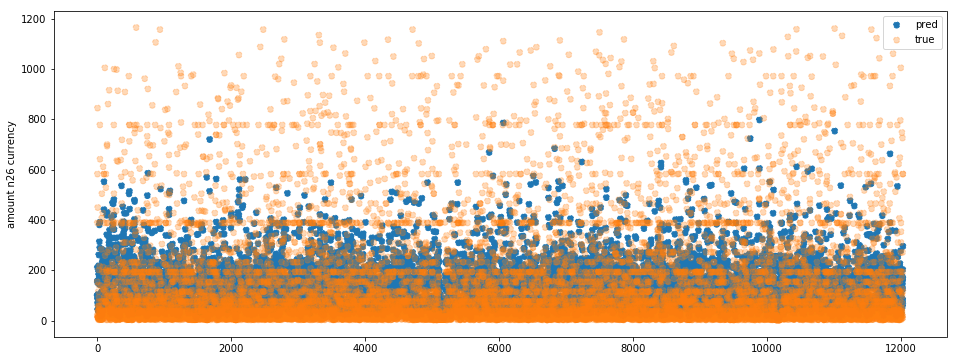

In [79]:
predictions = pd.DataFrame({'y_true': test['amount_n26_currency'], 'y_pred': np.exp(y_pred)})

plt.figure(figsize=(16,6))
plt.scatter(range(predictions.shape[0]), predictions['y_pred'], label='pred', linestyle='dashed',)
plt.scatter(range(predictions.shape[0]), predictions['y_true'], label='true', linestyle='dashed',alpha=0.3)
plt.ylabel('amount n26 currency')
plt.legend();

Like we saw above, the target variable is highly skewed, we observe here that the model predictions aren't going well for higher values of the target variable. Let's check the feature importance to understand which features are doing well.

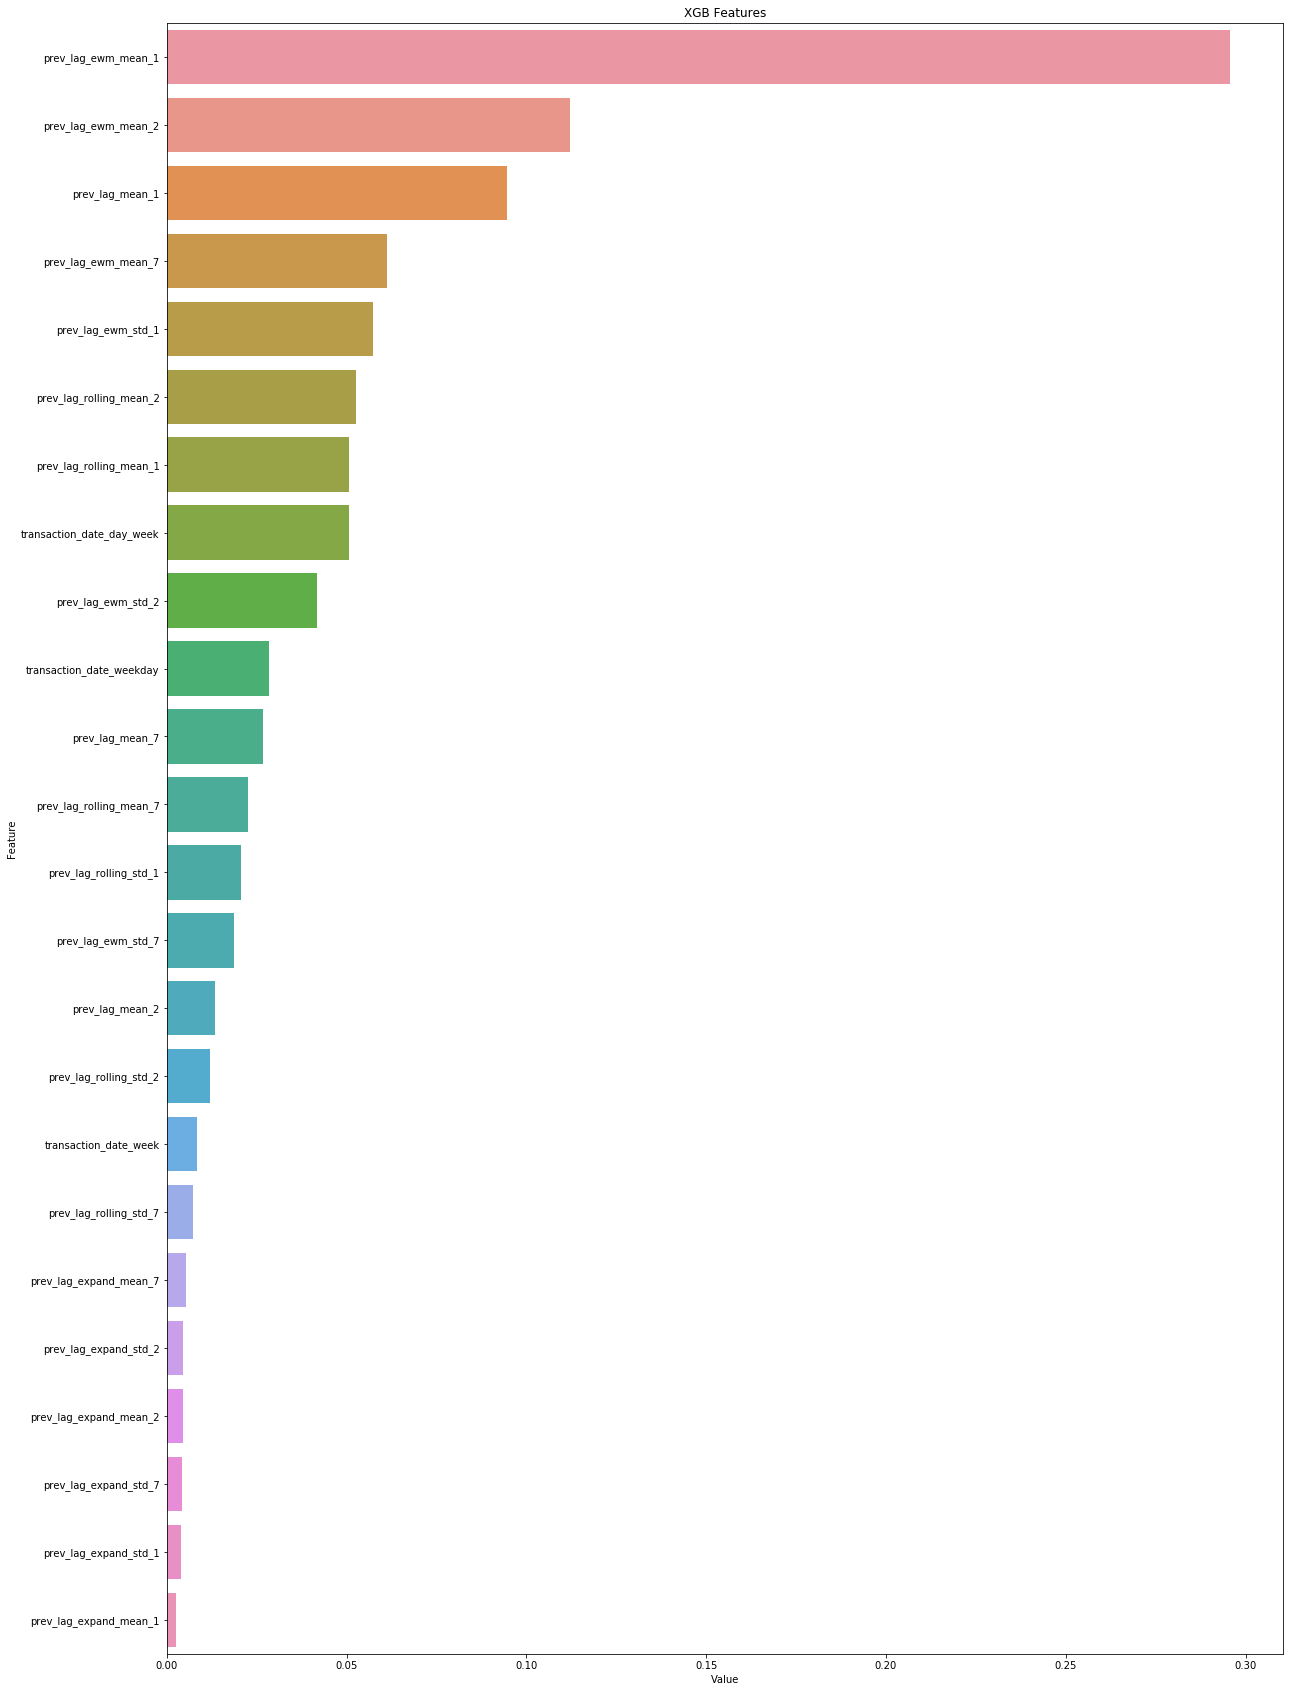

In [80]:
# plot feature importance
# search.best_estimator_.named_steps
feature_names = (model.named_steps['features'].named_transformers_['date_features'].get_feature_names() + 
                model.named_steps['features'].named_transformers_['time_series_features'].get_feature_names())

feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_ ,feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('XGB Features')
plt.show()

Let's plot the learning curve to understand if the model's performance is due to lack of data. 


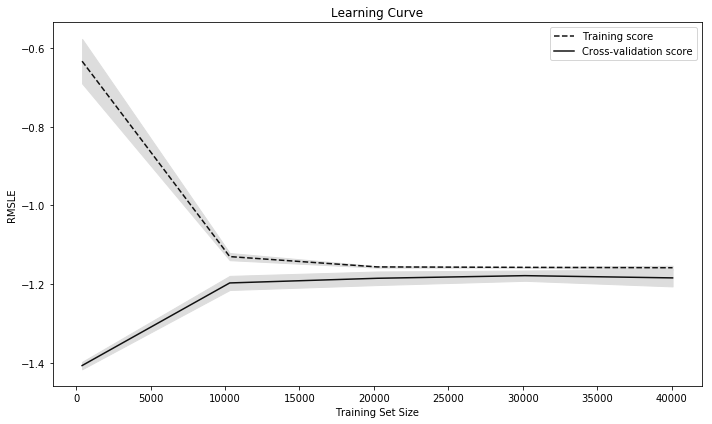

In [91]:
# make scorer
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(np.exp(y), np.exp(y_pred)))

ms = make_scorer(rmsle, greater_is_better=False)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(XGBRegressor(random_state=42), 
                                                        model.transform(train), 
                                                        y_train, 
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring=ms,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 10 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

We see that the learning saturates after 10,000 samples of data. So, our hypothesis is, the features created are not providing enough signal to the model.

We can make predictions for august month using the following function.

In [57]:
def makePrediction(model, data):
    
    """
    Dataset must have three columns as defined in columns list below.
    model: must be a sklearn pipeline object
    data: pandas dataframe with similar schema as train data
    """
    
    columns = ['user_id','transaction_date','amount_n26_currency']
    test = data[columns]
    test = test.sort_values(['user_id','transaction_date'])
    
    predictions = xgb.predict(model.transform(test))
    
    rmsle_score = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], np.exp(predictions)))
    print(f"RMSLE Score on the given data: {rmsle_score}")

In [ ]:
# makePrediction(model, aug_data)

### Expense Prediction

In [58]:
out_data = out_data.sort_values(['user_id','transaction_date']).reset_index(drop=True)

In [95]:
# split data set 
train = out_data[out_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
test = out_data[out_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july

y_train = np.log1p(train['amount_n26_currency'])

In [96]:
model = generate_pipeline()

In [97]:
# fit the pipeline
model.fit(train)

# initialise the model and fit
xgb = XGBRegressor(booster='gbtree', random_state=42)
xgb.fit(model.transform(train), y_train)

/anaconda3/envs/pyenv/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [98]:
# make prediction
y_pred = xgb.predict(model.transform(test))

Let's make baseline predictions.

In [99]:
baseline_model_predictions = [test['amount_n26_currency'].mean()]* test.shape[0]

In [100]:
rs = r2_score(test['amount_n26_currency'], baseline_model_predictions)
rmsle = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], baseline_model_predictions))
print(f"baseline model r2 score: {rs}")
print(f"baseline model rmsle score: {rmsle}")

baseline model r2 score: 0.0
baseline model rmsle score: 1.2434768770694895


Now, let's see how is our xgboost model doing.

In [101]:
rmsle_score = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], np.exp(y_pred)))
rsq_score = r2_score(test['amount_n26_currency'], np.exp(y_pred))
print(f"r2 score: {rsq_score}")
print(f"rmsle score: {rmsle_score}")

r2 score: -0.021853170694857482
rmsle score: 0.9896980863458293


r2 score is an estimate of how good the model is doing compared to mean predictions. In our case, since the target variable is skewed, the mean predictions cannot be used for benchmarking.

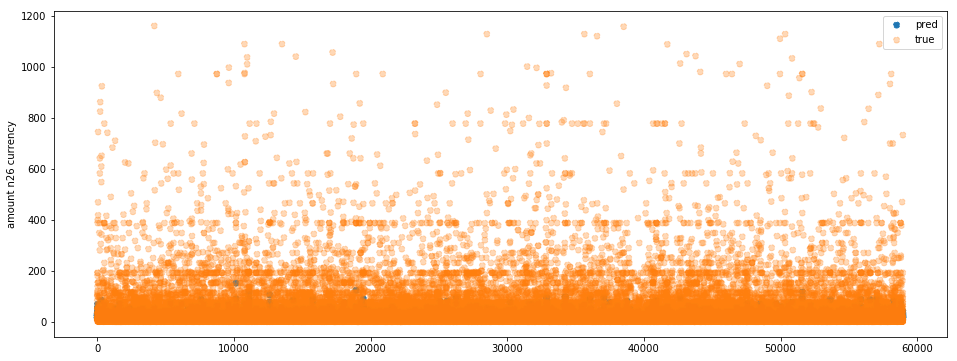

In [102]:
predictions = pd.DataFrame({'y_true': test['amount_n26_currency'], 'y_pred': np.exp(y_pred)})

plt.figure(figsize=(16,6))
plt.scatter(range(predictions.shape[0]), predictions['y_pred'], label='pred', linestyle='dashed',)
plt.scatter(range(predictions.shape[0]), predictions['y_true'], label='true', linestyle='dashed',alpha=0.3)
plt.ylabel('amount n26 currency')
plt.legend();

We see a similar distribution like we saw for income predictions.

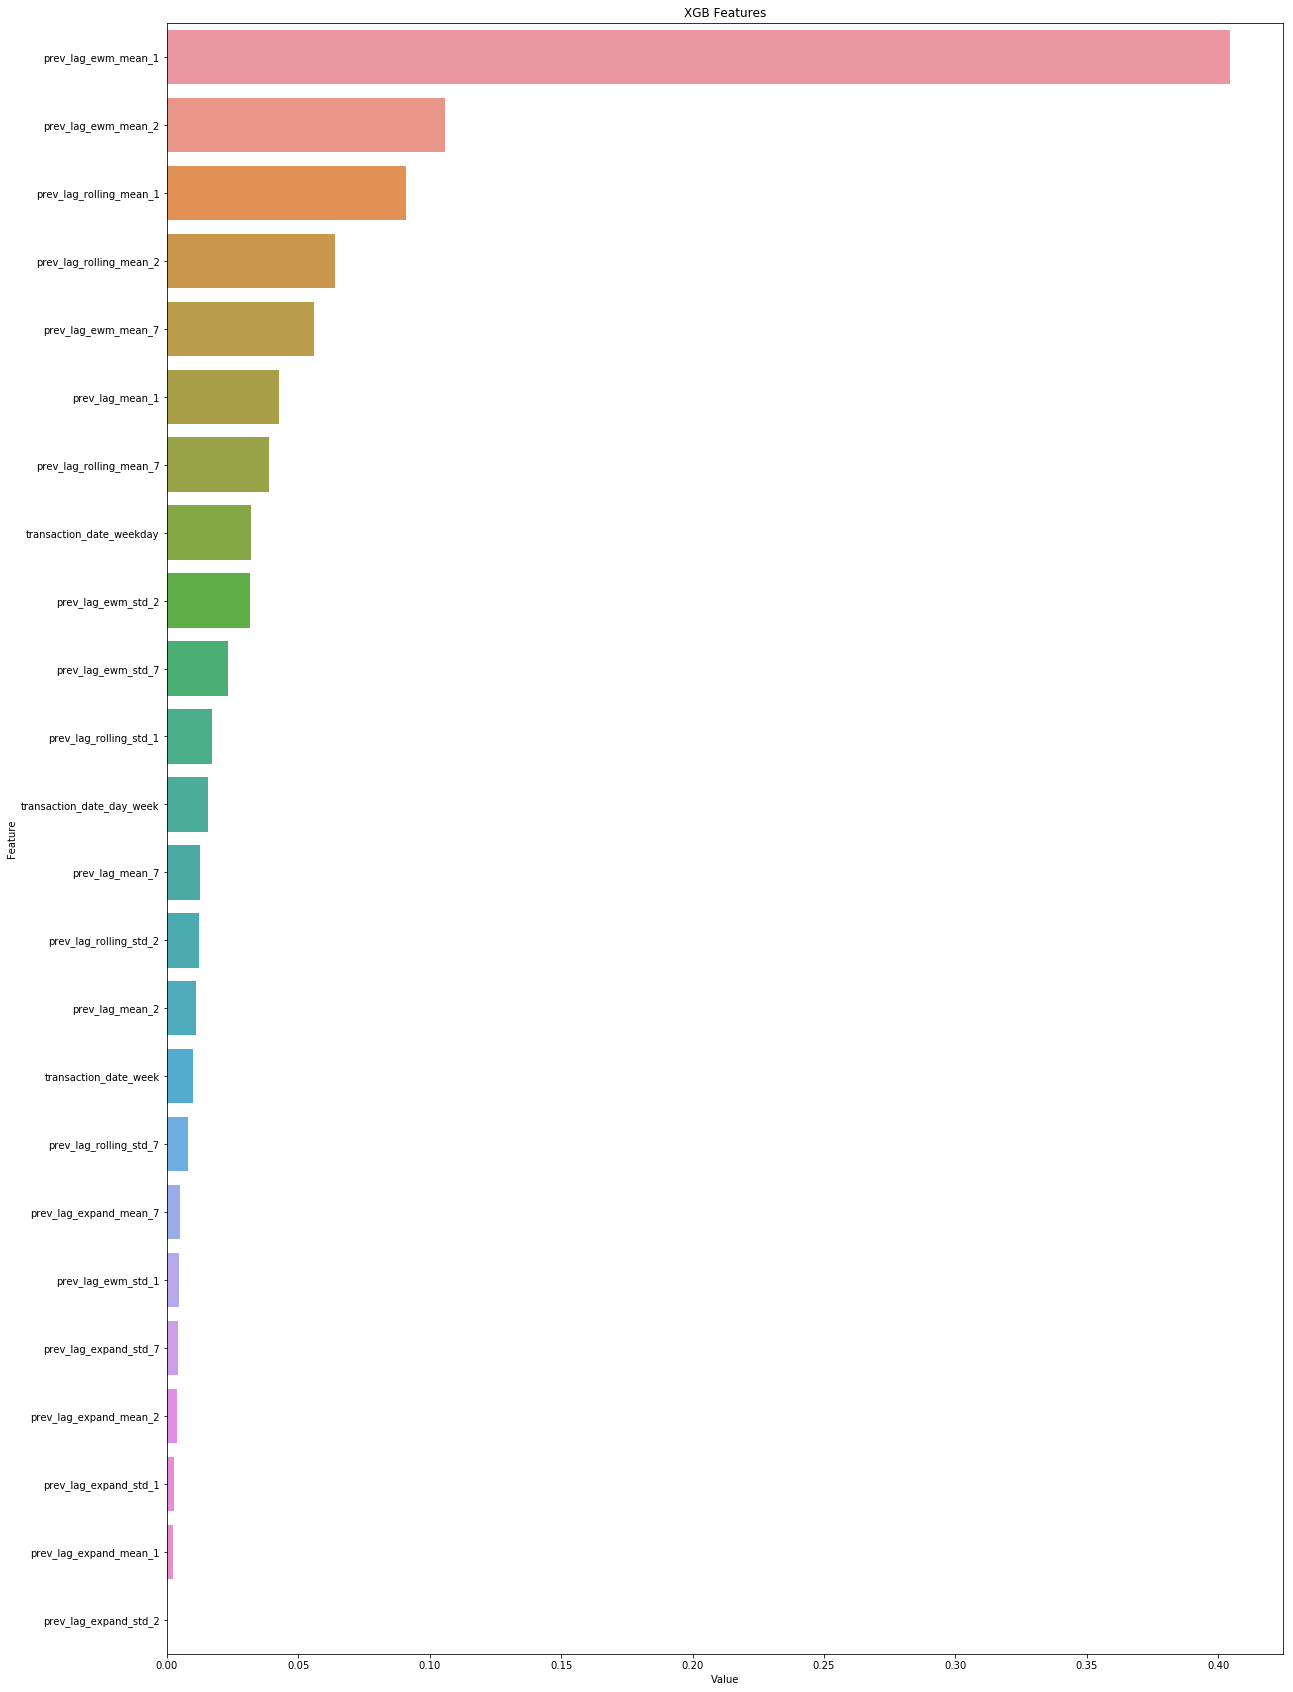

In [103]:
# plot feature importance
# search.best_estimator_.named_steps
feature_names = (model.named_steps['features'].named_transformers_['date_features'].get_feature_names() + 
                model.named_steps['features'].named_transformers_['time_series_features'].get_feature_names())

feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_ ,feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('XGB Features')
plt.show()

Let's plot the learning curve to understand if the model's performance is due to lack of data. 


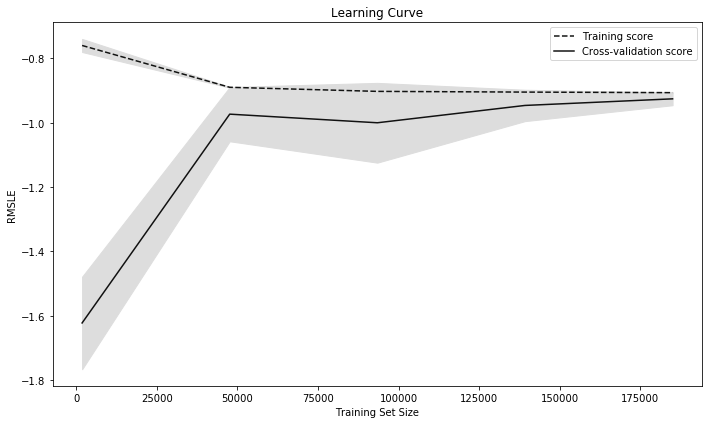

In [105]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(np.exp(y), np.exp(y_pred)))

ms = make_scorer(rmsle, greater_is_better=False)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(XGBRegressor(), 
                                                        model.transform(train), 
                                                        y_train, 
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring=ms,
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, '--', color="#111211",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

We see that the learning saturates after 150,000 samples of data.

In [ ]:
# makePrediction(model, aug_data)

**How confident can we be in the results ? Are they useful for the purpose of the original task ?**
 * It depends on the business requirement. If we have a baseline worse than this model, we could use this model to get some x% improvement in the metrics. However, this model is not the best one. We can do better.



**What performance metric would you use to evaluate the model?**

We used RMSLE as our performance metric because:
 * It doesn't penalises differences in large numbers as compared to RMSE which would inflate the error due to large difference in predictions among higher numbers.
 * The target variable is skewed, we would like a metric which can help us estimate the model performance on overall data rather than weighing the cases differently.

** Steps to production ** : First we need to understand the exact use case for this model.
1. We need to understand where (in app flow) we would like to use the model. For ex. would the model predictions be consumed by some other service and the prediction will be stored somewhere or the prediction score will be actively used to target the customers. 
2. Assuming the score will be used for targeting the customers, we can use the following stack:
 * Data Pipeline: Airflow to schedule data generation and model training stage.
 * Model Storage: Since our entire pipeline uses scikit-learn, we can use pickle format to save the model. Later, we can use other frameworks like ONNX to make the service faster.
 * API Creation: Python flask application to create and serve model endpoints
 * Testing: Do load testing / stress testing using JMeter framework to check the latency/concurrency of the service.
 * Deployment engine: We can deploy the service using ec2 instance / Kubernetes / Openshift cluster which manages service. 

** Next Steps / Possible Improvements **

To further improve the model, we can do the following:
* Separate the users into different categories (high value users vs low value vs mid value) and train model on each of these categories to better capture their transactional behaviour
* Get more data, for a longer period plus more features. The data could also have user-level profile features.
* Try classic time series based models (eg: ARIMA) and compare its performance with xgboost.
* Treat transaction as a sequence and try LSTM models.
* Perform error analysis. We'll always have cases where model performs worse. It's imperative to understand how the model is learning and what we should do to improve it.
* Try heuristics based models. Simple models can be better.